Library Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, confusion_matrix
)

from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")


Data Loading

In [27]:
DATA_PATH = r"D:\\codes\\brain tumor project yz\\infosys\\Data_set\\Main_data_set\\data_for_training.csv"

df = pd.read_csv(DATA_PATH, encoding="latin1")
print("Dataset loaded:", df.shape)

df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("(", "")
    .str.replace(")", "")
    .str.replace("°", "")
)


Dataset loaded: (22264, 34)


Data Inspection

In [28]:
TARGET = "pollution_source"

NUMERIC_FEATURES = [
    "co_aqi_value", "no2_aqi_value", "ozone_aqi_value",
    "pm2.5_aqi_value", "aqi_value",
    "temperature_c", "humidity_%", "wind_speed_m/s"
]

CATEGORICAL_FEATURES = ["weather_description"]

NUMERIC_FEATURES = [c for c in NUMERIC_FEATURES if c in df.columns]
CATEGORICAL_FEATURES = [c for c in CATEGORICAL_FEATURES if c in df.columns]

print("Numeric:", NUMERIC_FEATURES)
print("Categorical:", CATEGORICAL_FEATURES)


Numeric: ['co_aqi_value', 'no2_aqi_value', 'ozone_aqi_value', 'pm2.5_aqi_value', 'aqi_value', 'temperature_c', 'humidity_%', 'wind_speed_m/s']
Categorical: ['weather_description']


Data Cleaning

In [29]:
df = df.dropna(subset=[TARGET])

for col in NUMERIC_FEATURES:
    df[col] = df[col].fillna(df[col].median())

for col in CATEGORICAL_FEATURES:
    df[col] = df[col].fillna(df[col].mode()[0])


Encoding

In [30]:
label_encoders = {}

for col in CATEGORICAL_FEATURES:
    le = LabelEncoder()
    df[col + "_enc"] = le.fit_transform(df[col])
    label_encoders[col] = le

le_target = LabelEncoder()
df[TARGET] = le_target.fit_transform(df[TARGET])

print("Target classes:", le_target.classes_)


Target classes: ['Industrial' 'Natural' 'Vehicular']


Feature Scaling

In [31]:
df["traffic_pollution_index"] = (df["co_aqi_value"] + df["no2_aqi_value"]) / 2
df["particulate_ratio"] = df["pm2.5_aqi_value"] / (df["aqi_value"] + 1)
df["heat_humidity_index"] = df["temperature_c"] * df["humidity_%"] / 100

# Sensor noise
for col in NUMERIC_FEATURES:
    df[col] += np.random.normal(0, df[col].std() * 0.03, len(df))


Feature Engineering

In [32]:
FEATURES = (
    NUMERIC_FEATURES
    + ["traffic_pollution_index", "particulate_ratio", "heat_humidity_index"]
    + [c + "_enc" for c in CATEGORICAL_FEATURES]
)

X = df[FEATURES]
y = df[TARGET]


Noise Injection

In [33]:
def inject_label_noise(y, noise_ratio=0.18, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n = int(len(y) * noise_ratio)
    idx = np.random.choice(len(y), n, replace=False)
    classes = np.unique(y)

    for i in idx:
        y_noisy.iloc[i] = np.random.choice(classes[classes != y_noisy.iloc[i]])

    return y_noisy

y = inject_label_noise(y)


Train-Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Model Selection

Random Forest Training

In [35]:
rf = RandomForestClassifier(
    n_estimators=120,
    max_depth=6,
    min_samples_split=12,
    min_samples_leaf=8,
    max_features=0.6,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average="weighted")

print("Random Forest Accuracy:", round(rf_acc, 4))
print("Random Forest F1:", round(rf_f1, 4))


Random Forest Accuracy: 0.8217
Random Forest F1: 0.8169


Hyperparameter Tuning

              precision    recall  f1-score   support

  Industrial       0.80      0.61      0.69       896
     Natural       0.83      0.92      0.88      2324
   Vehicular       0.81      0.78      0.80      1233

    accuracy                           0.82      4453
   macro avg       0.81      0.77      0.79      4453
weighted avg       0.82      0.82      0.82      4453



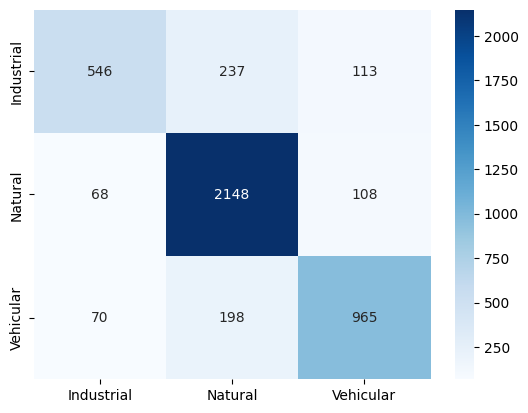

In [ ]:
print(classification_report(y_test, rf_pred, target_names=le_target.classes_))

cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.show()


In [37]:
df["distance_to_road_km"] = np.random.uniform(0.1, 5, len(df))
df["distance_to_industry_km"] = np.random.uniform(0.2, 8, len(df))
df["distance_to_traffic_hotspot_km"] = np.random.uniform(0.05, 3, len(df))


In [38]:
EXTRA_FEATURES = FEATURES + [
    "distance_to_road_km",
    "distance_to_industry_km",
    "distance_to_traffic_hotspot_km"
]

X_e = df[EXTRA_FEATURES]
y_e = y.copy()

X_tr, X_te, y_tr, y_te = train_test_split(
    X_e, y_e, test_size=0.2, stratify=y_e, random_state=42
)

scaler_e = StandardScaler()
X_tr = scaler_e.fit_transform(X_tr)
X_te = scaler_e.transform(X_te)


DecisionTree

In [51]:
dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=15,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42
)

dt.fit(X_tr, y_tr)
dt_pred = dt.predict(X_te)

dt_acc = accuracy_score(y_te, dt_pred)
dt_f1 = f1_score(y_te, dt_pred, average="weighted")

print("Decision Tree Accuracy:", round(dt_acc, 4))


Decision Tree Accuracy: 0.8159


XGBoost

In [40]:
xgb = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_tr, y_tr)
xgb_pred = xgb.predict(X_te)

xgb_acc = accuracy_score(y_te, xgb_pred)
xgb_f1 = f1_score(y_te, xgb_pred, average="weighted")

print("XGBoost Accuracy:", round(xgb_acc, 4))


XGBoost Accuracy: 0.8212


RandomizedSearchCV

In [41]:
param_grid = {
    "max_depth": [4, 5, 6],
    "min_samples_split": [10, 15, 20],
    "min_samples_leaf": [5, 8, 12]
}

dt_search = RandomizedSearchCV(
    DecisionTreeClassifier(class_weight="balanced", random_state=42),
    param_grid,
    n_iter=5,
    cv=3,
    scoring="f1_weighted",
    n_jobs=-1
)

dt_search.fit(X_tr, y_tr)


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [4, 5, ...], 'min_samples_leaf': [5, 8, ...], 'min_samples_split': [10, 15, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",5
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'f1_weighted'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` d

Results

In [42]:
results = pd.DataFrame({
    "Model": ["Random Forest", "Decision Tree", "XGBoost"],
    "Accuracy": [rf_acc, dt_acc, xgb_acc],
    "F1-score": [rf_f1, dt_f1, xgb_f1]
})

results


,Model,Accuracy,F1-score
0,Random Forest,0.821693,0.816895
1,Decision Tree,0.815854,0.811228
2,XGBoost,0.821244,0.816361


Top RF Features

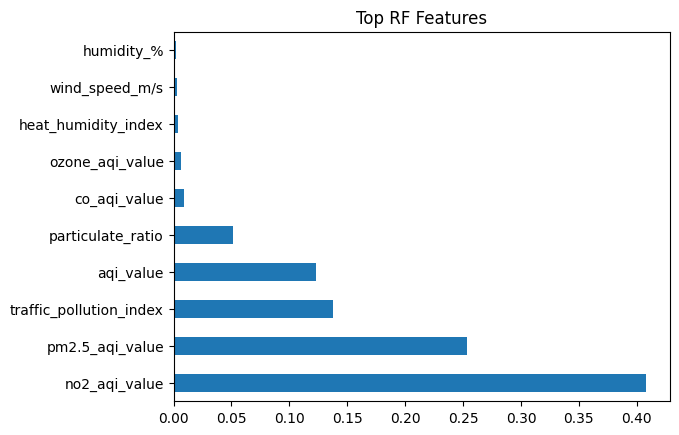

In [43]:
imp = pd.Series(rf.feature_importances_, index=FEATURES)
imp.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top RF Features")
plt.show()


In [49]:
joblib.dump(rf, "pollution_rf_realistic.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le_target, "target_encoder.pkl")

print("Models saved successfully")


Models saved successfully
